In [1]:
import networkx as nx
import pandas as pd
from typing import List, Dict, Tuple
import scipy as sp
import numpy as np
import math
import matplotlib.pyplot as plt

## Data gathering and cleaning

Our data is ...

Source: https://networks.skewed.de/net/fao_trade

### Data gathering

In [2]:
# target folder: where the data will be saved
target = "data/fao_trade"

# set it to True if you want to download the data
# download_data = True
download_data = False


In [3]:
if download_data:

    # data url source
    url = "https://networks.skewed.de/net/fao_trade/files/fao_trade.csv.zip"

    import urllib.request
    import zipfile
    import os

    # Create the data directory
    if not os.path.exists("data"):
        print("Creating data directory...")
        os.mkdir("data")

    # Download the data, unzip it and save it locally 
    print(f"Dowloading data from {url}...")
    f, _ = urllib.request.urlretrieve(url)
    print("Dowload OK!")

    with zipfile.ZipFile(f, 'r') as zip_ref:
        print("Extracting zip file...")
        zip_ref.extractall(target)
        print("Zip extraction OK!")

    print(f"Operation completed! Your CSV data is available at {target}")
     

### Data extraction and cleaning

Our data is made by 3 CSV files, that can be extracted into two `pandas.DataFrame` and one key-value `dict`.

1. `nodes` contains the list of countries and their attributes. Their only relevant attribute found in this dataset is the `name` of the country. The country name will be used as the node label.

2. `edges` contains all the weighted directed edges between countries(`source` and `target`). Each edge is labeled with the `layer` of the trade, that thanks to `gprops.layer_key` could be associated to a specific commodity. The weight of the edge is the value of the trade. 

    Before going on, we replace all the numerical indexes with testual values (both for countries and commodities).

3. `gprops` is a key-value which contains various meta-data, including the mapping between the `layer` and the commodity name.

NOTE: you may observe that our data does not describe a simple graph, but a multi-graph (a pair of nodes may have more than two directed edge between them). This is due to the fact that this dataset describes the trade of more than one commodity. We will see later how to deal with this.

Now we extract the data from CSV files, we clean it and then we will plot the head of the two `pandas.DataFrame` `nodes` and `edges`.

In [4]:
# --------------------------------------------------
# Extract nodes (as dataframe)

nodes = pd.read_csv(target + "/nodes.csv")
nodes.columns = nodes.columns.str.replace(" ", "")
nodes.columns = nodes.columns.str.replace("#", "")
nodes = nodes.set_index("index")

# drop redundant data
nodes = nodes.drop(["nodeLabel", "_pos"], axis="columns",)

# --------------------------------------------------
# Extract edges (as dataframe)

edges = pd.read_csv(target + "/edges.csv")
edges.columns = edges.columns.str.replace(" ", "")
edges.columns = edges.columns.str.replace("#", "")

# --------------------------------------------------
# Extract various graph properties (as dict)

gprops_df = pd.read_csv(target + "/gprops.csv", on_bad_lines='skip')
gprops_df.columns = gprops_df.columns.str.replace(" ", "")
gprops_df.columns = gprops_df.columns.str.replace("#", "")

# make a dict object out of the gprops dataframe
gprops = gprops_df.set_index("prop_name").to_dict()["value"]

# extract the layers keys (as a dict)
layer_keys = {}
for item in gprops["layer_key"] \
    .replace(" ", "").replace("\n", "") \
    .replace("{", "").replace("}", "") \
    .split("',"):

    keyvalue = item.split(":'")
    layer_keys[int(keyvalue[0])] = keyvalue[1]

gprops["layer_key"] = layer_keys

del layer_keys, gprops_df

# --------------------------------------------------
# replace numeric index with textual names

# replace country indexes in edges
edges["source"] = edges["source"].map(nodes["name"])
edges["target"] = edges["target"].map(nodes["name"])

# replace commodity indexes in edges
edges["layer"] = edges["layer"].map(gprops["layer_key"])

# set country name as node index
nodes = nodes.set_index("name")

In [5]:
nodes.head()

""
name
Afghanistan
Australia
Austria
Belgium
Brazil


In [6]:
edges.head()

,source,target,weight,layer
0,Afghanistan,Australia,6,Food_prep_nes
1,Afghanistan,France,14,Food_prep_nes
2,Afghanistan,Pakistan,1,Food_prep_nes
3,Afghanistan,United_Kingdom,13,Food_prep_nes
4,Afghanistan,United_States_of_America,3,Food_prep_nes


In [7]:
# show that there is more than one layer
edges[
    edges["source"].isin(['Afghanistan']) &
    edges["target"].isin(['Australia'])
]

,source,target,weight,layer
0,Afghanistan,Australia,6,Food_prep_nes
18,Afghanistan,Australia,1,"Flour,_wheat"
27,Afghanistan,Australia,8,Crude_materials
47,Afghanistan,Australia,8,"Fruit,_prepared_nes"
141,Afghanistan,Australia,2,"Nuts,_prepared_(exc._groundnuts)"
185,Afghanistan,Australia,3,Sugar_confectionery
211,Afghanistan,Australia,33,Raisins


In [8]:
# number of layers
len(edges["layer"].unique())

364

## Graph building

Here, in this section, we will build the graph from the data extracted in the previous section. We will also propose some solutions to deal the multi-layer problem.

### Deal the multi-layer problem

We propose three approaches to deal with the multi-layer problem:

1. First approach is a naive "filter and merge". If we are interested in analizing how the global trade works for some commodities, we can simply
   1. select only the edges that are related to the commodities we are interested in
   2. aggregate them by summing the weights of the edges between the same pair of nodes

    This way we obtain an unique aggregated directed and weighted graph, where each pair of nodes has at most two directed edges between them (one for each direction).

    If we are interested in analizing how the global trade works for all the commodities, we can simply keep all the edges and aggregate them.

2. Second approach is to build more graphs and then compare them. This approach may be useful if we want to compare differet commodities trades. Comparison may be done:
   1. comparing (normalized) topological and centrality indexes (also consiedering distribution)
   2. comparing different meso-scale structures with correlation indexes
   3. making visual comparison between matrixes plots

    We can also combine this approach with the first one to compare several "subsets" of the global trade.

3. Third approach is more peculiar. As discussed in https://www.nature.com/articles/ncomms7864, in a multi-layer graph, some layers are more similar or dissimilar than others; for this reason, aggregating dissimilar layer may introduce artificial structures that may be misleading. For this reason the article proposes an information theory based method to aggregate several layers withouth loosing too much information. Briefly, the article implement a sort of hierarchical clustering on the layers, where at each step you aggregate layers with similar import-export paths.

    This approach permits to obtain a smaller subset of relevant aggregated layers, that can be used to build a smaller number or comparable graphs.

In this notebook we will implement the first approach on the whole dataset. Then we will select some sample layers to make some comparisons.

### Build layers graphs

We start building a graph foreach layer. Then we also implement a function to merge graphs.

In [9]:
# extract the layers graphs 
def create_layers_graphs(edges: pd.DataFrame) -> Dict[str, nx.DiGraph]:
    """
    Create a dict of all graphs, one for each layer
    """

    layers_m = {}
    for layer in edges["layer"].unique():
        layers_m[layer] = nx.from_pandas_edgelist(
            edges[edges["layer"] == layer],
            source="source",
            target="target",
            edge_attr="weight",
            create_using=nx.DiGraph
        )
    return layers_m

layers_g = create_layers_graphs(edges)

In [10]:
def merge_weighted_graphs(G, H):
    """
    Merge two weighted graphs summing the weights of the edges in common.
    """

    g = nx.compose(G, H)
    edge_data = { e: G.edges[e]['weight'] + H.edges[e]['weight'] for e in G.edges & H.edges }
    nx.set_edge_attributes(g, edge_data, 'weight')
    return g

# merge all layers into a single graph
layers_names = list(layers_g.keys())
all_layers_g = layers_g[layers_names[0]]
for layer in layers_names[1:]:
    all_layers_g = merge_weighted_graphs(all_layers_g, layers_g[layer])


## Analysis on the whole dataset graph

Now we perform an analysis on the whole dataset graph (the one where all the layers are aggregated). 

This analaysis includes:
- an overview of the graph, with some simple topological indexes
- a calculation of some centrality indexes, an analysis of their distribution and a comparison between them
- ...

### Graph overview

With what kind of graph are we dealing with? Is it dense or is it sparse? Is it (strongly/weakly) connected?

In [160]:
# general graph properties
topological = {}

topological["n"] = len(all_layers_g.nodes)
topological["m"] = len(all_layers_g.edges)
topological["tot_weight"] = sum([all_layers_g.edges[e]['weight'] for e in all_layers_g.edges])
topological["density"] = topological["m"]/topological["n"]*(topological["n"]-1)

print(f"Nr. of nodes (Size): {topological['n']}")
print(f"Nr. of directed edges (Volume): {topological['m']}")
print(f"Total weight of directed edges: {topological['tot_weight']}")
print(f"Density: {round(topological['density'], 4)}")


Nr. of nodes (Size): 214
Nr. of directed edges (Volume): 13736
Total weight of directed edges: 1109494817
Density: 13671.8131


In [161]:
# Check if graph is connected
topological["weakly_connected"] = nx.is_weakly_connected(all_layers_g)
topological["strongly_connected"] = nx.is_strongly_connected(all_layers_g)

print("Weakly connected: ", topological["weakly_connected"])
print("Strongly connected: ", topological["strongly_connected"])

Weakly connected:  True
Strongly connected:  False


In [163]:
# Find SCC and their sizes 
scc = nx.strongly_connected_components(all_layers_g)

scc_sizes = [len(c) for c in sorted(scc, key=len, reverse=True)]

unique, counts = np.unique(scc_sizes, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Nr. of SCC with {u} nodes: {c}")


print(f"{scc_sizes[0]}/{topological['n']} ({round(scc_sizes[0]/topological['n'], 2)*100}%) nodes are in the largest SCC")

Nr. of SCC with 1 nodes: 81
Nr. of SCC with 133 nodes: 1
133/214 (62.0%) nodes are in the largest SCC


### Centrality indexes (pt. 1 - Friedman centralities) 

Which are the main nodes of the graph? Which are the main countries in the global trade (according to various measures)? What is the distribution of the centrality indexes? Is there any correlation between them? Which topological features may we derive from the centrality indexes?

In [47]:
# init a dataframe where I store all the centralities
centralities = pd.DataFrame(index=all_layers_g.nodes)

In [156]:
# degree centrality
centralities["in_degree"] = dict(all_layers_g.in_degree)
centralities["out_degree"] = dict(all_layers_g.out_degree)

# streght centrality (weighted degree)
centralities["in_strenght"] = dict(all_layers_g.in_degree(weight='weight'))
centralities["out_strenght"] = dict(all_layers_g.out_degree(weight='weight'))

# calculate difference between in and out strenght
centralities["out - in"] = centralities["out_strenght"] - centralities["in_strenght"]

In [71]:
# Calculate all the distances between nodes (ignoring weights)
dist = nx.floyd_warshall(all_layers_g, weight=None)

In [164]:
# Calculate closeness using distances

def calculate_all_closeness(distances: Dict[str, Dict[str, float]], n: int) \
    -> Tuple[Dict[str, float], Dict[str, float], Dict[str, float]]:
    """Calculate one-shot all the closeness centrality measures 
    (standard, excluding non reachable nodes, harmonic), given
    the distances between nodes."""

    closeness = {}
    closeness_excluding_non_reachable = {}
    harmonic_closeness = {}

    for node in all_layers_g.nodes:

        node_dist = 0
        node_dist_excluding_non_reachable = 0
        harmonic_closeness[node] = 0

        # calculate sum of distances for this node 
        for other_node in all_layers_g.nodes:
            if node != other_node:
                
                harmonic_closeness[node] += 1/dist[node][other_node]
                node_dist += dist[node][other_node]

                if dist[node][other_node] != np.inf:
                    node_dist_excluding_non_reachable += dist[node][other_node]

        # calculate closeness for this node
        closeness[node] = (n-1)/node_dist
        closeness_excluding_non_reachable[node] = (n-1)/node_dist_excluding_non_reachable
        harmonic_closeness[node] = harmonic_closeness[node]/(n-1)

    return closeness, closeness_excluding_non_reachable, harmonic_closeness


centralities["closeness"],  \
centralities["closeness_excl_non_reachable"], \
centralities["harmonic_closeness"] = calculate_all_closeness(dist, topological["n"])

In [128]:
# Calculate betweenness centrality
centralities["betweenness"] = nx.betweenness_centrality(all_layers_g)

We have built a dataset with some centrality indexes. What we can do now is:

1. select the top K countries, according to each centrality index
2. plot some distributions (expecially on degree and strength)
3. derive some topological features (we will do it later )
4. measure correlation between the centrality indexes (we will do it later when we will have more centrality indexes)




In [153]:
# def. a function to plot top K countries for a centrality measure

# build a color map for the countries
cmap = plt.get_cmap('twilight')
colors_vec = cmap(np.linspace(0, 1, len(centralities.index)))
colors = pd.Series({ node: colors_vec[i] for i, node in enumerate(centralities.index) })

def plot_top_k_centralities(centralities: pd.DataFrame, k: int, centrality_name: str):
    """
    Plot the top k countries by a centrality measure in a bar chart (using a color scale)
    """

    top_k = centralities.sort_values(by=centrality_name, ascending=False).head(k)

    c = colors.loc[top_k.index]
 
    plt.bar(top_k.index, top_k[centrality_name], color=c)
    plt.xticks(rotation=90)
    plt.title(f"Top {k} countries \nby {centrality_name}", fontsize=12)
    plt.tight_layout()

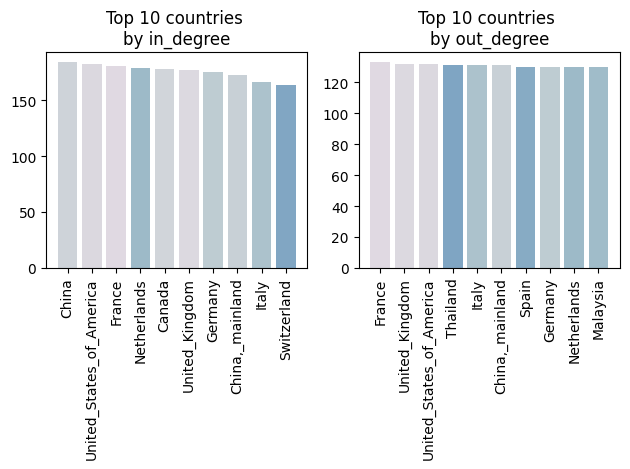

In [154]:
# top 10 in and out degree
plt.subplot(1, 2, 1)
plot_top_k_centralities(centralities, 10, "in_degree")

plt.subplot(1, 2, 2)
plot_top_k_centralities(centralities, 10, "out_degree")

plt.show()

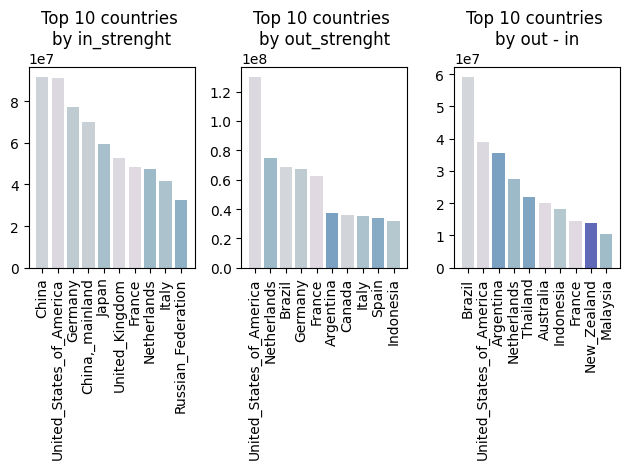

In [157]:
# top 10 in and out strenght (+ difference)
plt.subplot(1, 3, 1)
plot_top_k_centralities(centralities, 10, "in_strenght")

plt.subplot(1, 3, 2)
plot_top_k_centralities(centralities, 10, "out_strenght")

plt.subplot(1, 3, 3)
plot_top_k_centralities(centralities, 10, "out - in")

plt.show()

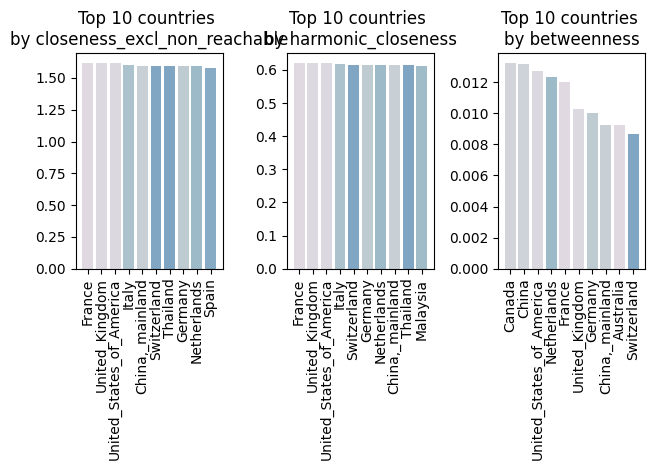

In [167]:
# top 10 closeness and betweenness
plt.subplot(1, 3, 1)
plot_top_k_centralities(centralities, 10, "closeness_excl_non_reachable")

plt.subplot(1, 3, 2)
plot_top_k_centralities(centralities, 10, "harmonic_closeness")

plt.subplot(1, 3, 3)
plot_top_k_centralities(centralities, 10, "betweenness")

plt.show()

In [168]:
# (NOTE: we can observe that all closeness are 0 because the graph is not connected)
centralities["closeness"].describe()

count    214.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: closeness, dtype: float64

In [177]:
# given the centralities, we may derive some topological measures

# calculate max and average degree
topological["max_in_degree"] = max(centralities["in_degree"])
topological["avg_in_degree"] = np.mean(centralities["in_degree"])
topological["max_out_degree"] = max(centralities["out_degree"])
topological["avg_out_degree"] = np.mean(centralities["out_degree"])

# calculate max and average strenghs
topological["max_in_strenght"] = max(centralities["in_strenght"])
topological["avg_in_strenght"] = np.mean(centralities["in_strenght"])
topological["max_out_strenght"] = max(centralities["out_strenght"])
topological["avg_out_strenght"] = np.mean(centralities["out_strenght"])

# calculate the diameter and the average distance
non_infty_dist = [d for node in dist.keys() for d in dist[node].values()  if d != np.inf]
topological["diameter"] = max(non_infty_dist)
topological["avg_distance"] = np.mean(non_infty_dist)


print("Max in degree: ", topological["max_in_degree"])
print("Avg in degree: ", topological["avg_in_degree"])
print("Max out degree: ", topological["max_out_degree"])
print("Avg out degree: ", topological["avg_out_degree"])
print("Max in strenght: ", topological["max_in_strenght"])
print("Avg in strenght: ", topological["avg_in_strenght"])
print("Max out strenght: ", topological["max_out_strenght"])
print("Avg out strenght: ", topological["avg_out_strenght"])
print("Max distance (Diameter) excluding infty: ", topological["diameter"])
print("Avg distance  excluding infty: ", topological["avg_distance"])


Max in degree:  184
Avg in degree:  64.18691588785046
Max out degree:  133
Avg out degree:  64.18691588785046
Max in strenght:  91670308
Avg in strenght:  5184555.219626168
Max out strenght:  130060548
Avg out strenght:  5184555.219626168
Max distance (Diameter) excluding infty:  3.0
Avg distance  excluding infty:  1.508566023193077


### Centrality indexes (pt. 2 - Clustering) 

What are the clustering coefficients of the network? How do they change if we consieder mutual relationships only?

In [207]:
# calculate nodes clustering coefficients
undir_g = all_layers_g.to_undirected()
undir_g_mutual_only = all_layers_g.to_undirected(reciprocal=True)

# calculate nodes clustering coefficients
centralities["clustering"] = nx.clustering(undir_g)
centralities["clustering_mutual_only"] = nx.clustering(undir_g_mutual_only)

# calculate Watts-Strogatz clustering coefficient
topological["watts_strogatz_clustering"] = np.mean(centralities["clustering"])
topological["watts_strogatz_clustering_mutual_only"] = np.mean(centralities["clustering_mutual_only"])

# calculate Newman clustering coefficient
def newmann_clustering(g: nx.Graph):

    # calculate actual triangles in the graph
    # (do not count the same triangle 3 times)
    n_triangles = sum(nx.triangles(g).values())/3 
    
    # calculate max # of triangles in the graph
    max_n_triangles = 0
    for node_degree in dict(g.degree()).values():
        max_n_triangles += node_degree*(node_degree-1)
  
    max_n_triangles /= 2    # do not couunt undirected paths twice
    max_n_triangles /= 3   # do not count the same triangle 3 times

    return n_triangles/max_n_triangles

topological["newmann_clustering"] = newmann_clustering(undir_g)
topological["newmann_clustering_mutual_only"] = newmann_clustering(undir_g_mutual_only)

print("Watts-Strogatz clustering: ", topological["watts_strogatz_clustering"])
print("Watts-Strogatz clustering (mutual only): ", topological["watts_strogatz_clustering_mutual_only"])
print("Newmann clustering: ", topological["newmann_clustering"])
print("Newmann clustering (mutual only): ", topological["newmann_clustering_mutual_only"])

Watts-Strogatz clustering:  0.8124991062175767
Watts-Strogatz clustering (mutual only):  0.5037041933256556
Newmann clustering:  0.7003534377654634
Newmann clustering (mutual only):  0.6928302663632101


Expected vs actual avg in degree:	 63.89 64.19
Expected vs actual avg out degree:	 63.89 64.19
Expected vs actual avg distance:	 1.29 1.51
Expected vs actual Watts-Strogatz clustering:			 0.3 0.81
Expected vs actual Watts-Strogatz clustering (mutual only):	 0.3 0.5
Expected vs actual Newmann clustering:				 0.3 0.7
Expected vs actual Newmann clustering (mutual only):		 0.3 0.69


### Centrality indexes (pt. 3 - Spectral Indexes and Random Walks) 

In [223]:
A = nx.adjacency_matrix(all_layers_g).todense()
np.all(A > 0)

False

In [225]:
# calculate eigenvalues and Spectral Ratio
eigvals = np.linalg.eigvals(A)
eigvals_abs = np.abs(eigvals)
topological["spectral_ratio"] = max(eigvals_abs)

print("Spectral ratio: ", topological["spectral_ratio"])
print("Is spectral ratio an eigenvalue?", topological["spectral_ratio"] in eigvals)
print("Is spectral ratio dominant?", topological["spectral_ratio"] > max(eigvals_abs[1:]))
print("Is spectral ratio simple?", list(eigvals).count(topological["spectral_ratio"]) == 1)

Spectral ratio:  33708163.19482666
Is spectral ratio an eigenvalue? True
Is spectral ratio dominant? False
Is spectral ratio simple? True


NOTES:
- `A` is not `> 0`, so Perron theorem does not apply
- `A` is reducible (associated graph is not strongly connected), so neither Frobenius applies
- spectral ratio is an eigevalue but is not dominant, so Power Method does not necessarily converge

In [226]:
nx.pagerank(all_layers_g)
nx.pagerank(all_layers_g.reverse())

{'Afghanistan': 0.0020895650097348976,
 'Australia': 0.009141143505640282,
 'France': 0.034974793478973115,
 'Pakistan': 0.004847377302790281,
 'United_Kingdom': 0.033899953877936366,
 'United_States_of_America': 0.06417560918485204,
 'Austria': 0.009634967270785073,
 'Belgium': 0.01898612531203543,
 'Brazil': 0.004485142897805842,
 'Canada': 0.017057725013276046,
 'China': 0.05060997341912731,
 'China,_Hong_Kong_SAR': 0.026993070442234035,
 'China,_mainland': 0.032459839264804176,
 'China,_Taiwan_Province_of': 0.011341028006212528,
 'Denmark': 0.008226408066471886,
 'Germany': 0.050003501563785434,
 'India': 0.010345699698805978,
 'Indonesia': 0.010792408482022635,
 'Iran_(Islamic_Republic_of)': 0.0062139793922285505,
 'Ireland': 0.00724752328327153,
 'Italy': 0.029512261974113753,
 'Japan': 0.044229472581138345,
 'Lebanon': 0.006479360916685458,
 'Malaysia': 0.010370885564234558,
 'Netherlands': 0.0307670341774868,
 'Philippines': 0.004107695608572641,
 'Poland': 0.009880226037374778

### Network non-randomness, degree distributions and models

Given the centralities and the topological measures, which properties are explained by randomnness and which are not? Which network model may explain our network?

In [ ]:
# calculate some expected properties (in a random network) and compare them with the actual ones

p = topological["m"]/pow(topological["n"], 2)

topological_expected = {} 

topological_expected["avg_in_degree"] = topological_expected["avg_out_degree"] = p*(topological["n"]-1)
topological_expected["avg_distance"] = np.log(topological["n"])/np.log(topological_expected["avg_out_degree"])

topological_expected["watts_strogatz_clustering"] = \
    topological_expected["watts_strogatz_clustering_mutual_only"] = \
    topological_expected["newmann_clustering"] = \
    topological_expected["newmann_clustering_mutual_only"] = p

print("Expected vs actual avg in degree:\t", 
    round(topological_expected["avg_in_degree"], 2), 
    round(topological["avg_in_degree"], 2))
print("Expected vs actual avg out degree:\t", 
    round(topological_expected["avg_out_degree"], 2),
    round(topological["avg_out_degree"], 2))
print("Expected vs actual avg distance:\t", 
    round(topological_expected["avg_distance"], 2),
    round(topological["avg_distance"], 2))
print("Expected vs actual Watts-Strogatz clustering:\t\t\t", 
    round(topological_expected["watts_strogatz_clustering"], 2),
    round(topological["watts_strogatz_clustering"], 2))
print("Expected vs actual Watts-Strogatz clustering (mutual only):\t", 
    round(topological_expected["watts_strogatz_clustering_mutual_only"], 2),
    round(topological["watts_strogatz_clustering_mutual_only"], 2))
print("Expected vs actual Newmann clustering:\t\t\t\t", 
    round(topological_expected["newmann_clustering"], 2),
    round(topological["newmann_clustering"], 2))
print("Expected vs actual Newmann clustering (mutual only):\t\t", 
    round(topological_expected["newmann_clustering_mutual_only"], 2),
    round(topological["newmann_clustering_mutual_only"], 2))